In [2]:
#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter

!pip install pandas
!pip install seaborn
#!pip install sklearn
#!pip install numpy

In [3]:
!sudo pip install numpy
!sudo pip install scipy
!sudo pip install -U scikit-learn

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory 

In [10]:
#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

#load a default seaborn dataset, display simple stats about data size, and then print the data's head
df = pd.DataFrame(sns.load_dataset('iris'))
print 'shape of the data frame'+str(df.shape)
print df.groupby(['species']).size()
#df.head(50)

shape of the data frame(150, 5)
species
setosa        50
versicolor    50
virginica     50
dtype: int64


In [ ]:
#showoff some of what seaborn can do
sns.pairplot(df, hue="species", diag_kind="kde",markers=['o','x','+'])

In [5]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['species']=='versicolor', 1,0)
print df.groupby(['y']).size()

y
0    100
1     50
dtype: int64


In [ ]:
df.head(15)

In [6]:
#split into train and test
X=df.drop('species',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))


the number in training set: 112
the number in test set: 38


In [22]:
from sklearn.linear_model import SGDClassifier

clf2 = SGDClassifier(loss="hinge", penalty="l2")
clf2.fit(X, y)
SGDClassifier(alpha=0.00001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [23]:
#Randomized search for model selection
#clf = RandomForestClassifier(n_estimators=10)
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"penalty": ['l1', 'l2', 'elasticnet'],
              "loss": ['hinge','modified_huber','log']}

# run randomized search
n_iter_search = 8
random_search = RandomizedSearchCV(clf2, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV examined 8 candidate parameter settings.
Model with rank: 1
Mean OOB score: 0.696 (std: 0.009)
Parameters: {'penalty': 'elasticnet', 'loss': 'log'}

Model with rank: 2
Mean OOB score: 0.688 (std: 0.011)
Parameters: {'penalty': 'l1', 'loss': 'log'}

Model with rank: 3
Mean OOB score: 0.661 (std: 0.059)
Parameters: {'penalty': 'l1', 'loss': 'hinge'}

Model with rank: 3
Mean OOB score: 0.661 (std: 0.047)
Parameters: {'penalty': 'l2', 'loss': 'hinge'}

Model with rank: 5
Mean OOB score: 0.571 (std: 0.183)
Parameters: {'penalty': 'elasticnet', 'loss': 'hinge'}



In [30]:
#2.5 Train the random forest according to the best paramater setting given above. Show model outputs.

#YOUR HOMEWORK IS TO SWITCH RANDOM FOREST CLASSIFIED WITH ANOTHER CLASSIFIER FROM THE SCIKIT LEARN API
#http://scikit-learn.org/stable/

# these are hard coded based on the above results.
#clf = RandomForestClassifier(n_estimators=50, oob_score=True, max_features=3, criterion='gini',
#                             bootstrap=True,min_samples_split=3,min_samples_leaf=3,max_depth=3)

clf = SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
clf = clf.fit(X_train, y_train)

#importances = clf.feature_importances_
names = X.columns
#items=sorted(zip(map(lambda r: round(r, 3), clf.feature_importances_), names), reverse=True)

#print ('\nfeature importance ')
#for r in items:
#    print(str(round(r[0],4))+' '+r[1])
    
y_pred=clf2.predict(X_test)
y_scores=clf2.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))

#show a tradeoff curve for precision vs recall


confusion matrix
Predicted   0  All
True              
0          22   22
1          16   16
All        38   38

auc score 0.686079545455


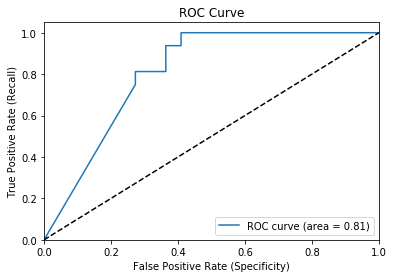

In [31]:
#2.7 ROC Curve
fpr, tpr , threshold = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Specificity: How many negatives were identified as negative.
plt.xlabel('False Positive Rate (Specificity)')
#Recall: How many positives were identified as positive.
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
#code to save your model to disk and then to s3
import pickle
local_path = "/home/ubuntu" # temp path to export your model
bucket_name = "my-bucket-glen-c" # s3 key to save your network to

# save the model to disk
filename = 'GlenC_HW2_SGD.sav'
pickle.dump(clf, open(filename, 'wb'))
#you should now see your finalized_model.sav in the file path
#the ls command prints the contents of this notebook's root folder
!ls
 
# Upload to S3
#TO GET THIS WORKING, YOU MUST ASSIGN AN ADMIN ROLE TO YOUR EC2 INSTANCE
import boto3
s3 = boto3.resource('s3')
s3.Bucket(bucket_name).put_object(Key='GlenC_HW2_SGD.sav', Body=open('GlenC_HW2_SGD.sav'))

finalized_model.sav	intro_to_python_data_science_on_aws.ipynb
GCancian_HW2_Sub.ipynb	my_local_pickle.sav
GlenC_HW2_SGD.sav


s3.Object(bucket_name='my-bucket-glen-c', key='GlenC_HW2_SGD.sav')

In [ ]:
# some time later...
 
# load the model from s3 and make new predictions
s3.Bucket(bucket_name).download_file(filename, 'my_local_pickle.sav')
loaded_model = pickle.load(open('my_local_pickle.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [38]:
#note that you can now call this model saved in S3 from ANY internet connected location

#now push your notebook to your github page and submit the link as your homework
#instructions: https://www.howtoforge.com/tutorial/install-git-and-github-on-ubuntu-14.04/
#identify your username
!git config --global user.name "Glen-C"
#make a local git repository
!git init 95852-ADS_BIDA
#navigate to the repo
cd 95852-ADS_BIDA/
#create a README
!echo "this is my README file" >>README
#move your notebook into the git folder (you will need to re-enter your notebook interface after moving the file)
!mv /home/ubuntu/GCancian_HW2_Sub.ipynb /home/ubuntu/HW2/
#make a new repo for yourself within your github.com account
#add the files that you just made to tracking
!git add GCancian_HW2_Sub.ipynb
!git add README
#then remote add the github repo that you just made
!git remote add origin https://github.com/Glen-C/95852-ADS_BIDA.git
#then push your files to the git account
!git push origin master
#you will be prompted to enter your security credentials


#if this isn't working for you, another option is to download the file to your local machine using the following:
#sudo scp -r -i 'yourkeypair.pem' ubuntu@publicDNS:/home/ubuntu/intro_to_python_data_science_on_aws.ipynb localpath
#windows people should use something like FileZilla to transfer files from a linux EC2 server to a local windows machine


SyntaxError: invalid syntax (<ipython-input-38-02db28457611>, line 10)